# TIMESERIES 1 CLICK
---

File number: 01

In [135]:
# Import libraries
import os, time, enum
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Deep Learning
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
keras_models = tf.keras.models
keras_layers = tf.keras.layers
keras_loss = tf.keras.losses
keras_optimizer = tf.keras.optimizers
keras_metric = tf.keras.metrics
keras_preprocess = tf.keras.preprocessing.sequence
keras_callback = tf.keras.callbacks

In [136]:
# CONFIG VARIABLES
DATASET = 'PhuLien' # 'NiveauMer', 'PhuLien'
N_MISSING_SPACE = 2
MISSING_PERCENTAGE = 3
REMOVED_MODE = 'Random' # 'Linear', 'Random'
RANDOM_SEED = 42
KARMAN_FILTER = False

In [137]:
# MODEL CONFIGS
WINDOW_SIZE = 10
BATCH_SIZE = 1
EPOCHS = 10
SCALER = MinMaxScaler()
LOSS = keras_loss.MeanSquaredError()
OPTIMIZER = keras_optimizer.Adam()
# LAYERS CONFIGS
MODEL_LAYERS = [
    keras_layers.LSTM(128, activation='relu', return_sequences=True),
    keras_layers.Dropout(0.2),
    keras_layers.LSTM(2**5, activation='relu'),
    keras_layers.Dropout(0.2),
    keras_layers.Dense(1)
]
# Nếu True, model sẽ train trên tập data được chia làm đôi, mỗi tập được loại bỏ missing và nối lại
# Nếu False, model sẽ train trên 2 data không missing ngay cạnh khu vực missing
IS_CONCAT_PIPELINE = True
# Nếu True, mỗi khu vực missing sẽ được train trên 1 model riêng
# Nếu False, tất cả khu vực missing sẽ được train trên 1 model
IS_DISCRETE_MODEL = False
# Nếu True, mỗi chiều sẽ được train trên 1 model riêng
# Nếu False, tất cả chiều sẽ được train trên 1 model
IS_2_SIDE_MODEL = True

In [138]:
# Với tập data được xử lý, 2 cột mặt định là 'Time' và 'WaterLevel'
# Thay đổi tên nếu tên cột khác
x_col_name = 'Time'
y_col_name = 'WaterLevel'

# Training Model Part Begin 👇

### Class Definition

In [139]:
# Data Splitting Mode
class SplitMode(enum.Enum):
    # Mode: Random, Linear
    Random = 'Random'
    Linear = 'Linear'

    # Get SplitMode from string
    # @param: string [str] - Charactor represent SplitMode
    # @return: SplitMode instance [SplitMode]
    @staticmethod
    def get_from_string(string: str) -> 'SplitMode':
        if string == SplitMode.Random.value:
            return SplitMode.Random
        elif string == SplitMode.Linear.value:
            return SplitMode.Linear
        else:
            raise ValueError('Invalid split_mode')

# Create Missing DataFrame
class CreateMissingDataFrame:
    '''
    To create missing dataframe, data is splited into `missing_gaps` parts.\n
    Each part will remove a similar amount of missing data. An mount defined by `missing_percentage`% of entire data.\n
    If `split_mode` is `SplitMode.Random`, each part will remove randomly on this part.\n
    If `split_mode` is `SplitMode.Linear`, each part will remove the center data on this part.\n
    '''
    def __init__(self, dataframe: pd.DataFrame, missing_percentage: float, missing_gaps: int, seed: int = None, split_mode: Union[SplitMode, str] = SplitMode.Random):
        # Original Dataframe [pd.DataFrame]
        self.dataframe: pd.DataFrame = dataframe
        # Missing percentage for each gap [float]
        self.missing_percentage: float = missing_percentage
        # Amount of missing gaps [int]
        self.missing_gaps: int = missing_gaps
        # Seed for random [int]
        self.seed = seed
        # If split mode is string, convert to SplitMode instance [SplitMode]
        self.split_mode: SplitMode = SplitMode.get_from_string(split_mode) if isinstance(split_mode, str) else split_mode
        # Null value [pd.NA]
        self.empty_value = pd.NA
        # Dropped dataframe [pd.DataFrame]
        self.dropped_dataframe: pd.DataFrame = None
        # List of pair missing index [list[tuple[int, int]]]
        self.missing_indexs: list[tuple[int, int]] = None

    # When call method, implement dropping dataframe and assign to dropped_dataframe
    # @param: None
    # @return: None
    def dropping_dataframe(self):
        # Set random seed of numpy. If seed is None, unset seed
        if self.seed is not None:
            np.random.seed(self.seed)
        else:
            np.random.default_rng(0)
        
        # Init list of missing index
        mising_indexs = []

        # Get amount of value can be missing
        # length of dataframe * missing_percentage / 100 [int]
        missing_amount = int(self.dataframe.shape[0] * self.missing_percentage / 100)

        # Copy dataframe to working_dataframe to prevent change original dataframe
        working_dataframe = self.dataframe.copy()

        # Length of each part for missing_gaps
        # length of dataframe / missing_gaps [int]
        part_index = int(self.dataframe.shape[0] / self.missing_gaps)

        # Split dataframe in Random mode
        # How it work:
        # - Define the dataframe that will be affected: splited_dataframe
        # - Get safe random zone: safe_random_zone
        #   Ex: if data has 1000 rows, missing_amount = 100, safe_random_zone = 900.
        #   In case random algorithm return 900, it will have enough space to drop 100 value
        # - Get random index: random_index
        # - Get missing index: upper_index, lower_index
        # - Add missing index to list
        # - Drop value by assign empty_value to dataframe
        if self.split_mode == SplitMode.Random:
            for n in range(self.missing_gaps):
                # Split dataframe
                splited_dataframe = working_dataframe[part_index * n: part_index * (n + 1)]
                # Get random index
                safe_random_zone = splited_dataframe.shape[0] - missing_amount
                random_index = np.random.randint(0, safe_random_zone)
                # Get missing index
                upper_index = part_index * n + random_index
                lower_index = upper_index + missing_amount
                # Add missing index to list
                mising_indexs.append((upper_index, lower_index))
                # Drop value
                working_dataframe[upper_index: lower_index] = self.empty_value
        
        # Split dataframe in Linear mode
        # How it work:
        # - Define offset: offset
        #   Offset is the begining index for missing data
        #   Ex: if data has 1000 rows, missing_amount = 100, offset = 450.
        #   Thus, missing data will be in range [450, 550] which is the middle of missing part
        # - Get missing index: upper_index, lower_index
        # - Add missing index to list
        # - Drop value by assign empty_value to dataframe
        elif self.split_mode == SplitMode.Linear:
            for n in range(self.missing_gaps):
                # Get missing index
                offset = (part_index // 2 - missing_amount // 2)
                upper_index = part_index * n + offset
                lower_index = upper_index + missing_amount
                # Add missing index to list
                mising_indexs.append((upper_index, lower_index))
                # Drop value
                working_dataframe[upper_index: lower_index] = self.empty_value

        # Save dropped dataframe and missing index
        self.dropped_dataframe = working_dataframe
        self.missing_indexs = mising_indexs

In [140]:
# Downloader function, use to download file from url to Colab temporary disk
def downloader(url: str, root_path: str, file_name: str = 'data'):
    # Create data folder if not exist
    if not os.path.isdir(root_path):
        os.mkdir(root_path)
    # Clear data folder
    os.system(f'rm -rf {root_path}/*')
    # Download data
    os.system(f'wget -P {root_path} {url}')
    time.sleep(3)
    # Rename file
    os.system(f'mv {root_path}/* {root_path}/{file_name}.csv')

In [141]:
# Scaler Abstract Class
# Each scaler that imported from sklearn.preprocessing should have fit, fit_transform, inverse_transform method
# Using abstract method for code suggestion
class ScalerAbstract:
    def __init__(self): ...

    def fit(self, X: np.ndarray) -> None:
        raise NotImplementedError

    def fit_transform(self,  X: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def inverse_transform(self,  X: np.ndarray) -> np.ndarray:
        raise NotImplementedError

class SingleNetImputation:
    '''
    Imputation using single net model.\n
    This model used single model config to impute all missing data.\n
    By default, how it work:
    - Split dataframe into pipeline and reverse_pipeline, pipeline is normal way, reverse_pipeline is reverse way
    - Create model `m` and assign to `model`
    - Using model `m` to train pipeline then predict the missing data
    - Using model `m` to train reverse_pipeline then predict the missing data
    - Mean two predictions
    - Continue with other missing part by continuous training on `m`\n
    If `is_discreated_model` is True, model will use different model for each missing index.\n
    How it work:
    - Split dataframe into pipeline and reverse_pipeline, pipeline is normal way, reverse_pipeline is reverse way
    - Using model `m1` to train pipeline then predict the missing data
    - Using model `m1` to train reverse_pipeline then predict the missing data
    - Mean two predictions
    - Create new model (re-assign to `model`) and continue with other missing part\n
    If `is_two_side_model` is True, model will use different model for each side of pipeline.\n
    How it work:
    - Split dataframe into pipeline and reverse_pipeline, pipeline is normal way, reverse_pipeline is reverse way
    - Create 2 models `m1` and `m2`, which is assigned to `model` and `side_model`
    - Using model `m1` to train pipeline then predict the missing data
    - Using model `m2` to train reverse_pipeline then predict the missing data
    - Mean two predictions
    - Continue with other missing part
    '''
    def __init__(
        self,
        dataframe: pd.DataFrame,
        missing_indexs: list[tuple[int, int]],
        window_size: int,
        batch_size: int,
        epochs: int,
        scaler: ScalerAbstract = None,
        is_concat_pipeline: bool = True,
        is_discreated_model: bool = False,
        is_two_side_model: bool = False
    ):
        # Full dataframe [pd.DataFrame]
        self.dataframe = dataframe
        # List of missing indexs [list[tuple[int, int]]]
        self.missing_indexs = missing_indexs
        # If is_concat_pipeline is False,
        # Pipeline and reverse_pipeline only take a closest non missing part around missing part [bool]
        self.is_concat_pipeline = is_concat_pipeline
        # Model [keras.models.Sequential], init is None
        self.model: tf.keras.models.Sequential = None
        # Window size, Model use set of data and labeled with next data [int]
        self.window_size = window_size
        # Batch size, Model use batch_size data to train [int]
        self.batch_size = batch_size
        # Epochs, Model train epochs times [int]
        self.epochs = epochs
        # Scaler class, init is None [ScalerAbstract]
        self.scaler = scaler
        # Feature size, number of feature in dataframe [int]
        # If dataframe is pd.DataFrame, feature_size = dataframe.shape[1], else feature_size = 1
        self.feature_size = dataframe.shape[1] if isinstance(dataframe, pd.DataFrame) else 1
        # Is discreated model, if True, using different model for each missing index [bool]
        self.is_discreated_model: bool = is_discreated_model
        # Is two side model, if True, using different model for each side of pipeline [bool]
        self.is_two_side_model: bool = is_two_side_model
        # Side model [keras.models.Sequential], init is None
        self.side_model: tf.keras.models.Sequential = None
        # Model config for model layers, loss, optimizer [dict]
        self.model_config = dict()
        # Histories to save history callbacks [list[keras.callbacks.History]]
        self.histories = []

    # When call method, implement model config and assign to model_config
    # This config will be used to create model and compile model
    # @param: layers [list[keras_layer]] - List of keras layer
    # @param: loss [keras_loss] - Keras loss
    # @param: optimizer [keras_optimizer] - Keras optimizer
    # @return: None
    def config_model(self, layers, loss='mse', optimizer=keras_optimizer.Adam()):
        self.model_config['layers'] = layers
        self.model_config['loss'] = loss
        self.model_config['optimizer'] = optimizer

    # When call method, implement split dataframe and return pipeline and reverse_pipeline
    # How it work:
    # - Pipeline is dataframe from 0 to missing_index[0]
    #   If is_concat_pipeline is False, pipeline is dataframe from last na value to missing_index[0]
    # - Reverse pipeline is dataframe from missing_index[1] to end
    #   If is_concat_pipeline is False, reverse_pipeline is dataframe from missing_index[1] to first na value
    # - Dropna value on pipeline and reverse_pipeline
    #   Dropping na value is important because model can't train with na value
    # - Reverse reverse_pipeline
    # @param: dataframe [np.ndarray] - Dataframe to split
    # @param: index [tuple[int, int]] - Index of missing data
    # @return: pipeline [np.ndarray], reverse_pipeline [np.ndarray]
    def __dataframe_spliter(self, dataframe: np.ndarray, index: tuple[int, int]):
        # Pipeline
        pipeline = dataframe[:index[0]]
        # Reverse pipeline
        reverse_pipeline = dataframe[index[1]:]
        # is_concat_pipeline is False
        if not self.is_concat_pipeline:
            # Last na index
            last_na_index = np.where(np.isnan(dataframe))[0]
            last_na_index = last_na_index[-1] if len(last_na_index) > 0 else 0
            # First na index
            first_na_index = np.where(np.isnan(dataframe))[0]
            first_na_index = first_na_index[0] if len(first_na_index) > 0 else dataframe.shape[0]
            # Pipeline
            pipeline = dataframe[last_na_index:]
            # Reverse pipeline
            reverse_pipeline = dataframe[:first_na_index]
        # Dropna and reverse reverse_pipeline
        pipeline = pd.DataFrame(pipeline).dropna().to_numpy()
        reverse_pipeline = pd.DataFrame(reverse_pipeline).dropna().iloc[::-1].to_numpy()
        # Return pipeline
        return pipeline, reverse_pipeline

    # When call method, implement create, compile model and assign to model
    # @param: None
    # @return: model [tf.keras.models.Sequential]
    def __create_model(self):
        # Init model
        model = keras_models.Sequential()
        # Add Input layer
        # Instead of using input_shape on first Neural Network layer, using InputLayer
        model.add(keras_layers.InputLayer(input_shape=(self.window_size, self.feature_size)))
        # Add layers
        for layer in self.model_config['layers']:
            model.add(layer)
        # Compile model
        model.compile(loss=self.model_config['loss'], optimizer=self.model_config['optimizer'])
        # Return model
        return model

    # When call method, return keras_preprocess.TimeseriesGenerator
    # @param: dataframe [pd.DataFrame] - Dataframe to generate
    # @return: generator [keras_preprocess.TimeseriesGenerator]
    def __generator(self, dataframe: pd.DataFrame):
        return keras_preprocess.TimeseriesGenerator(dataframe, dataframe, length=self.window_size, batch_size=self.batch_size)
    
    # When call method, implement prediction and return predictions
    # In Deep Learning model, it use a set of `window_size` data to predict next data
    # @param: dataframe [np.ndarray] - Dataframe to predict
    # @param: future_amount [int] - Amount of future data to predict
    def __prediction(self, dataframe: np.ndarray, future_amount: int):
        # Init prediction list
        predictions = []
        # Init batch, a set of data to predict next data
        batch = dataframe[-self.window_size:].reshape((1, self.window_size, self.feature_size))
        # Predict
        for _ in range(future_amount):
            # Predict next data
            prediction = self.model.predict(batch)[0]
            # Add prediction to predictions
            predictions.append(prediction)
            # Update batch, new batch is old batch without first data and add prediction to last
            batch = np.append(batch[:, 1:, :], [[prediction]], axis=1)
        return np.array(predictions)
    
    # When call method, implement imputation and return predictions
    # How it work:
    # - Create model if is_discreated_model or model is None
    #   By default, when first call, model is None, so it will create model.
    #   If is_discreated_model is True, create new model and assign to self.model when method is called
    #   If is_two_side_model is True, when first call, create 2 models and assign to self.model and self.side_model
    # - Transform pipeline and reverse_pipeline to (-1, feature_size) shape
    # - Create generator, reverse_generator, early_stop, history
    # - Fit generator, reverse_generator
    #   If is_two_side_model is True, use side_model to fit reverse_generator
    # - Predict generator, reverse_generator
    # - Save history
    # - Mean pipeline_predictions and reverse_pipeline_predictions
    # - Return final_predictions
    def __imputation(self, pipeline: np.ndarray, reverse_pipeline: np.ndarray, missing_index: tuple[int, int]):
        # Create model
        if self.is_discreated_model:
            self.model = self.__create_model()
        if self.model is None:
            self.model = self.__create_model()
        if self.is_two_side_model and self.is_discreated_model:
            self.side_model = self.__create_model()
        if self.is_two_side_model and self.side_model is None:
            self.side_model = self.__create_model()
        # Transform pipeline
        pipeline = pipeline.reshape((-1, self.feature_size))
        reverse_pipeline = reverse_pipeline.reshape((-1, self.feature_size))
        # Create generator
        generator = self.__generator(pipeline)
        reverse_generator = self.__generator(reverse_pipeline)
        # Create early stop
        pipeline_early_stop = keras_callback.EarlyStopping(monitor='loss', patience=2)
        reverse_pipeline_early_stop = keras_callback.EarlyStopping(monitor='loss', patience=2)
        # Create history
        pipeline_history = keras_callback.History()
        reverse_pipeline_history = keras_callback.History()
        # Fit generator
        # Only fit if length of pipeline > window_size
        if pipeline.shape[0] > self.window_size:
            self.model.fit(generator, epochs=self.epochs, callbacks=[pipeline_early_stop, pipeline_history])
        # Predict generator
        pipeline_predictions = self.__prediction(pipeline, missing_index[1] - missing_index[0])
        # Fit reverse_generator
        # If is_two_side_model is True, use side_model to fit reverse_generator
        # Only fit if length of reverse_pipeline > window_size
        if reverse_pipeline.shape[0] > self.window_size:
            if self.is_two_side_model:
                self.side_model.fit(reverse_generator, epochs=self.epochs, callbacks=[reverse_pipeline_early_stop, reverse_pipeline_history])
            else:
                self.model.fit(reverse_generator, epochs=self.epochs, callbacks=[reverse_pipeline_early_stop, reverse_pipeline_history])
        # Predict reverse_generator
        reverse_pipeline_predictions = self.__prediction(reverse_pipeline, missing_index[1] - missing_index[0])[::-1]
        # Save history
        self.histories.append(pipeline_history)
        self.histories.append(reverse_pipeline_history)
        # Mean pipeline_predictions and reverse_pipeline_predictions
        final_predictions = np.mean([pipeline_predictions, reverse_pipeline_predictions], axis=0)
        return final_predictions

    # When call method, implement update dataframe
    def __update_dataframe(self, missing_index: tuple[int, int], predictions: np.ndarray):
        # Reshape predictions, from (n, 1) to (n,)
        predictions = predictions.squeeze()
        # Update dataframe
        self.dataframe[missing_index[0]: missing_index[1]] = predictions

    # When call method, implement fit model step by step
    # How it work:
    # - If scaler is not None, fit scaler
    # - Loop through missing indexs and impute
    # - Split dataframe
    # - Imputation
    # - Update dataframe
    # @param: None
    # @return: None
    def fit(self):
        # If scaler is not None, fit scaler
        if self.scaler:
            reshaped_dataframe = self.dataframe.values.reshape((-1, self.feature_size))
            self.scaler.fit(reshaped_dataframe)
            dataframe_scaled = self.scaler.fit_transform(reshaped_dataframe)
        # Else, use dataframe
        else:
            dataframe_scaled = self.dataframe
        # Loop through missing indexs and impute
        for missing_index in self.missing_indexs:
            # Split dataframe
            pipeline, reverse_pipeline = self.__dataframe_spliter(dataframe_scaled, missing_index)
            # Imputation
            predictions = self.__imputation(pipeline, reverse_pipeline, missing_index)
            # Update dataframe, now the missing part is filled
            actual_predictions = self.scaler.inverse_transform(predictions) if self.scaler else predictions
            self.__update_dataframe(missing_index, actual_predictions)

In [142]:
# Metrics
def similarity(y_true: np.ndarray, y_pred: np.ndarray):
    return np.sum(1 / (1 + np.abs(y_true - y_pred))) / y_true.shape[0]

def nmae(y_true: np.ndarray, y_pred: np.ndarray):
    return np.sum(np.abs(y_true - y_pred)) / y_true.shape[0]

def r2(y_true: np.ndarray, y_pred: np.ndarray):
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    return np.sum((y_true - y_true_mean) * (y_pred - y_pred_mean)) / np.sqrt(np.sum((y_true - y_true_mean) ** 2) * np.sum((y_pred - y_pred_mean) ** 2))

def rmse(y_true: np.ndarray, y_pred: np.ndarray):
    return np.sqrt(np.sum((y_true - y_pred) ** 2) / y_true.shape[0])

def fsd(y_true: np.ndarray, y_pred: np.ndarray):
    y_true_sd = np.std(y_true)
    y_pred_sd = np.std(y_pred)
    return 2 * np.abs(y_true_sd - y_pred_sd) / (y_true_sd + y_pred_sd)

def fb(y_true: np.ndarray, y_pred: np.ndarray):
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    return 2 * (y_pred_mean - y_true_mean) / (y_pred_mean + y_true_mean)

def fa2(y_true: np.ndarray, y_pred: np.ndarray, upper_bound: float = 2.0, lower_bound: float = 0.5):
    y = y_pred / y_true
    return np.where((y >= lower_bound) & (y <= upper_bound))[0].shape[0] / y_true.shape[0]

In [143]:
def handle_df_outlier(df_in): 
    df_outlier = pd.DataFrame(columns=['Col', 'Index', 'Value']) 
    for col in df_in.columns: 
        if df_in[col].dtypes != 'O': 
            Q1 = df_in[col].quantile(0.25) 
            Q3 = df_in[col].quantile(0.75) 
            IQR = Q3 - Q1 
            outlier = df_in[(df_in[col] < (Q1 - 3 * IQR)) | (df_in[col] > (Q3 + 3 * IQR))] 
            if len(outlier) > 0: 
                df_outlier = pd.concat([df_outlier, pd.DataFrame({'Col': [col]*len(outlier), 'Index': outlier.index, 'Value': outlier[col]})], ignore_index=True)
            # Repalce outlier with NaN 
            df_in.loc[df_outlier[df_outlier['Col'] == col]['Index'], col] = np.nan 
            # Replace NaN with mean 
            df_in[col] = df_in[col].fillna(df_in[col].mean())
    return df_in

### Load data

In [144]:
# Data constants (ONLY FOR COLAB)
# download_links = {
#     'NiveauMer': 'https://drive.google.com/uc?id=1Y-o-J0XzQ6itiSlQ7fLg5vQkIRlXjHRM&export=download',
#     'PhuLien': 'https://drive.google.com/uc?id=1q1_ZOVr2FRRrDPp4uA9C_4EsrkVtYn4_&export=download'
# }
# root_path = '/content/data'
# downloader(url=download_links[DATASET], root_path=root_path, file_name=DATASET)

In [145]:
# Read dataframe (ONLY FOR COLAB)
# dataframe = pd.read_csv(f'{root_path}/{DATASET}.csv')
# Read dataframe. If running on local, put csv file in same folder with this file
dataframe = pd.read_csv(f'{DATASET}.csv')

In [146]:
# Remove outlier
dataframe = handle_df_outlier(dataframe)

### Create Missing

In [147]:
# Create missing data class instance
# Put configs in CONFIG VARIABLES section into CreateMissingDataFrame
missing_dropper = CreateMissingDataFrame(
    dataframe=dataframe, 
    missing_percentage=MISSING_PERCENTAGE,
    missing_gaps=N_MISSING_SPACE,
    seed=RANDOM_SEED,
    split_mode=REMOVED_MODE)
# Dropping dataframe to create missing data
missing_dropper.dropping_dataframe()

In [148]:
# Get dropped dataframe and missing indexs
working_dataframe = missing_dropper.dropped_dataframe[y_col_name]
missing_indexs = missing_dropper.missing_indexs
# Print missing indexs, for debug
missing_indexs

[(102, 122), (606, 626)]

### Train Models

In [149]:
# Create SingleNetImputation instance
# Put configs in MODEL CONFIGS section into SingleNetImputation
single_net_imputation = SingleNetImputation(
    dataframe=working_dataframe,
    missing_indexs=missing_indexs,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    scaler=SCALER,
    is_concat_pipeline=IS_CONCAT_PIPELINE,
    is_discreated_model=IS_DISCRETE_MODEL,
    is_two_side_model=IS_2_SIDE_MODEL)

In [150]:
# Config model
# Put configs in MODEL CONFIGS section into SingleNetImputation.config_model
single_net_imputation.config_model(
    layers=MODEL_LAYERS,
    loss=LOSS,
    optimizer=OPTIMIZER)

In [151]:
# Fit model
time_start = time.time() # Start time
single_net_imputation.fit()
time_end = time.time() # End time

Epoch 1/10


92/92 [==============================] - 3s 6ms/step - loss: 0.0532
Epoch 2/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0303
Epoch 3/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0320
Epoch 4/10
1/1 [==============================] - 0s 16ms/step
Epoch 1/10
520/520 [==============================] - 4s 6ms/step - loss: 0.0311
Epoch 2/10
520/520 [==============================] - 3s 5ms/step - loss: 0.0297
Epoch 3/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0294
Epoch 4/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0283
Epoch 5/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0282
Epoch 6/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0268
Epoch 7/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0249
Epoch 8/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0245
Epoch 9/10
520/520 [==============================] - 2s 4ms/st

C:\Users\Doan Quang Minh\AppData\Local\Temp\ipykernel_16724\2830583520.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[missing_index[0]: missing_index[1]] = predictions


576/576 [==============================] - 3s 4ms/step - loss: 0.0259
Epoch 2/10
576/576 [==============================] - 2s 4ms/step - loss: 0.0250
Epoch 3/10
576/576 [==============================] - 2s 4ms/step - loss: 0.0231
Epoch 4/10
576/576 [==============================] - 3s 6ms/step - loss: 0.0235
Epoch 5/10
576/576 [==============================] - 3s 5ms/step - loss: 0.0221
Epoch 6/10
576/576 [==============================] - 3s 6ms/step - loss: 0.0223
Epoch 7/10
576/576 [==============================] - 2s 4ms/step - loss: 0.0220
Epoch 8/10
576/576 [==============================] - 3s 4ms/step - loss: 0.0213
Epoch 9/10
576/576 [==============================] - 2s 4ms/step - loss: 0.0222
Epoch 10/10
1/1 [==============================] - 0s 16ms/step
Epoch 1/10
36/36 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 2/10
36/36 [==============================] - 0s 4ms/step - loss: 0.0202
Epoch 3/10
36/36 [==============================] - 0s 4ms/s

C:\Users\Doan Quang Minh\AppData\Local\Temp\ipykernel_16724\2830583520.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[missing_index[0]: missing_index[1]] = predictions


In [152]:
# Update original dataframe with imputed data
dataframe['Imputed'] = single_net_imputation.dataframe

# Comparison

### Configs

In [153]:
# Slice dataframe
sliced_dataframe = pd.DataFrame()
for missing_index in missing_indexs:
    sliced_dataframe = pd.concat([sliced_dataframe, dataframe[missing_index[0]: missing_index[1]]], ignore_index=True)

In [154]:
plt.style.use('seaborn')

C:\Users\Doan Quang Minh\AppData\Local\Temp\ipykernel_16724\240305066.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Charts

Text(0.5, 1.0, 'Actual vs Imputed: PhuLien-2,3,Random,42,False-w10,bs1,ep10')

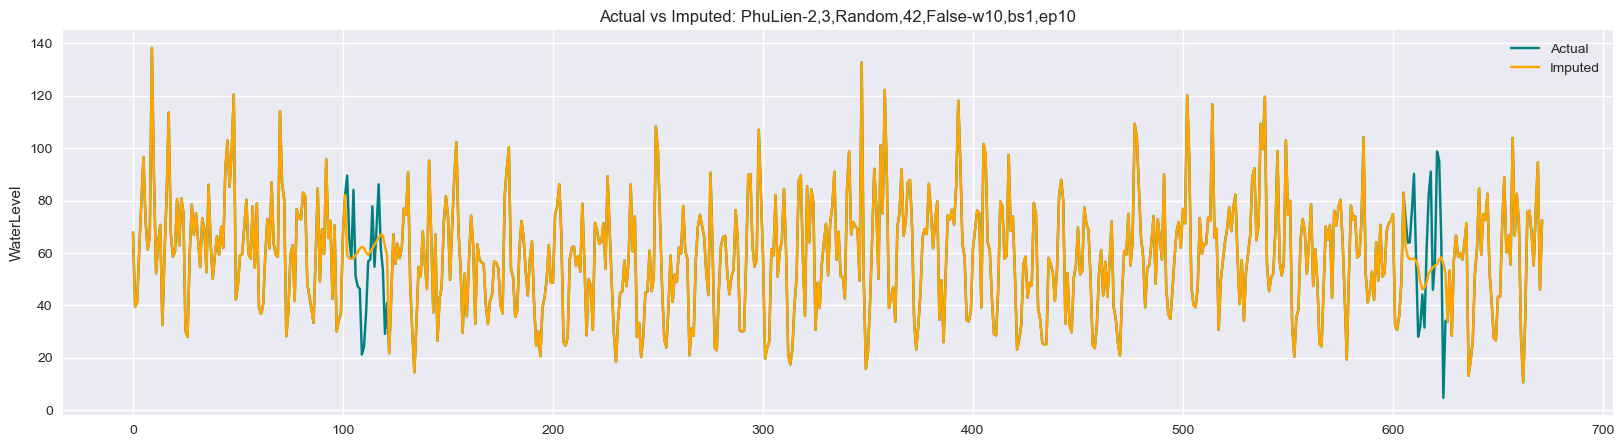

In [155]:
# Plot full dataframe
plt.figure(figsize=(20, 5))
sns.lineplot(dataframe[y_col_name], color='teal', label='Actual')
sns.lineplot(dataframe['Imputed'], color='orange', label='Imputed')
plt.title(f'Actual vs Imputed: {DATASET}-{N_MISSING_SPACE},{MISSING_PERCENTAGE},{REMOVED_MODE},{RANDOM_SEED},{KARMAN_FILTER}-w{WINDOW_SIZE},bs{BATCH_SIZE},ep{EPOCHS}')

Text(0.5, 1.0, 'Actual vs Imputed Sliced: PhuLien-2,3,Random,42,False-w10,bs1,ep10')

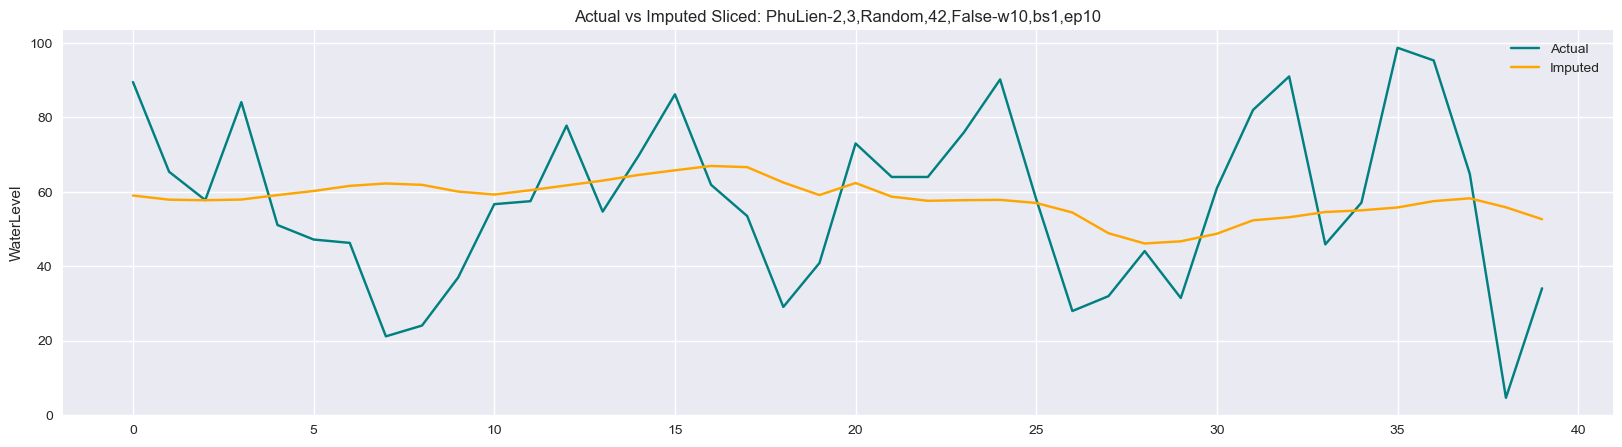

In [156]:
# Plot sliced dataframe
plt.figure(figsize=(20, 5))
sns.lineplot(sliced_dataframe[y_col_name], color='teal', label='Actual')
sns.lineplot(sliced_dataframe['Imputed'], color='orange', label='Imputed')
plt.title(f'Actual vs Imputed Sliced: {DATASET}-{N_MISSING_SPACE},{MISSING_PERCENTAGE},{REMOVED_MODE},{RANDOM_SEED},{KARMAN_FILTER}-w{WINDOW_SIZE},bs{BATCH_SIZE},ep{EPOCHS}')

### Metrics

In [157]:
# Metrics
print('Metrics for Imputed region')
print(f'Similarity: {similarity(sliced_dataframe[y_col_name], sliced_dataframe["Imputed"])}')
print(f'NMAE: {nmae(sliced_dataframe[y_col_name], sliced_dataframe["Imputed"])}')
print(f'R2: {r2(sliced_dataframe[y_col_name], sliced_dataframe["Imputed"])}')
print(f'RMSE: {rmse(sliced_dataframe[y_col_name], sliced_dataframe["Imputed"])}')
print(f'FSD: {fsd(sliced_dataframe[y_col_name], sliced_dataframe["Imputed"])}')
print(f'FB: {fb(sliced_dataframe[y_col_name], sliced_dataframe["Imputed"])}')
print(f'FA2: {fa2(sliced_dataframe[y_col_name], sliced_dataframe["Imputed"])}')
print('\nMetrics for Entire data')
print(f'Similarity: {similarity(dataframe[y_col_name], dataframe["Imputed"])}')
print(f'NMAE: {nmae(dataframe[y_col_name], dataframe["Imputed"])}')
print(f'R2: {r2(dataframe[y_col_name], dataframe["Imputed"])}')
print(f'RMSE: {rmse(dataframe[y_col_name], dataframe["Imputed"])}')
print(f'FSD: {fsd(dataframe[y_col_name], dataframe["Imputed"])}')
print(f'FB: {fb(dataframe[y_col_name], dataframe["Imputed"])}')
print(f'FA2: {fa2(dataframe[y_col_name], dataframe["Imputed"])}')

Metrics for Imputed region
Similarity: 0.12409616444722545
NMAE: 17.744334106445315
R2: 0.12407617209814151
RMSE: 22.25477153048485
FSD: 1.2774391205859341
FB: 0.005341455789962608
FA2: 0.9

Metrics for Entire data
Similarity: 0.9478628669313823
NMAE: 1.0562103634788877
R2: 0.9668614747866566
RMSE: 5.4296082900132765
FSD: 0.03226745753873886
FB: 0.0003100567928682931
FA2: 0.9940476190476191


### Training Time

In [158]:
# Time calculator
print(f'Time in second: {time_end - time_start}')

Time in second: 61.72235321998596


### Loss

<Axes: >

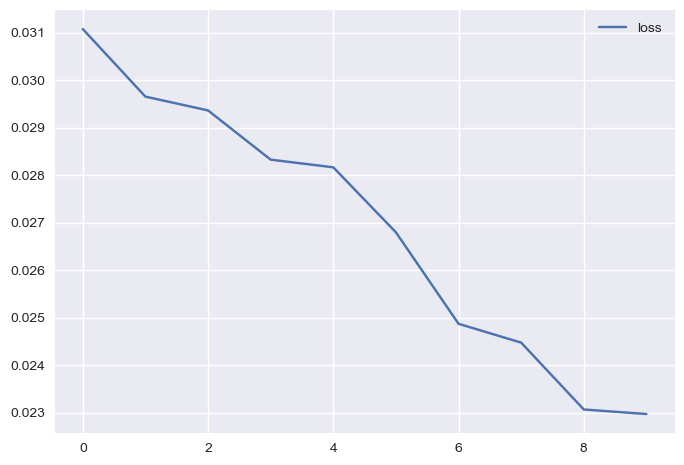

In [159]:
sns.lineplot(single_net_imputation.histories[1].history)